In [1]:
# load important modules
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif, RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load dataset
data = pd.DataFrame(pd.read_excel('data/sarcopenia.xlsx'))
print(data.shape)
print("serve sarcopenia: ", data[data['Sarcopenia']==1].shape[0])
print("mild sarcopenia: ", data[data['Sarcopenia']==2].shape[0])

# drop duplicated rows
data.drop(data[data.drop("Folio", axis=1).duplicated()].index, inplace=True)
print("shape after dropped duplicates: ", data.shape)
print("serve sarcopenia: ", data[data['Sarcopenia']==1].shape[0])
print("mild sarcopenia: ", data[data['Sarcopenia']==2].shape[0])

# Genero 1: male, 2: female => change to 0: male, 1: female
# SI: 1, NO: 2 => change to NO: 0, YES: 1
data['Genero'] = data['Genero'].replace({1: 0, 2: 1})

# overview of data
print("shape:", data.shape)
print("\"Misses\" in:")
print(data.loc[:,data.isna().any()].info())
print("Indexes of rows with misses:", data[data.isna().any(axis=1)].index)

#print(data['Marcha'].value_counts(dropna=False).sort_index())
#print(data['Hb'].value_counts(dropna=False).sort_index())
#print("Columns:\n",data.columns)
#data.describe()


# HB: 0 = NaN
data['Hb'].fillna(0, inplace=True)
# treating nans
# Marcha: 0 = NaN => 8 NaN can be imputed with mean
data['Marcha'].fillna(data['Marcha'].mean(), inplace=True)
data['Marcha'] = data['Marcha'].replace({0:data['Marcha'].mean()})


# Change encoding, so that 0 always equals ninguno/-a or regular, depending on the scale
data['Cuidador'].replace({6 : 0}, inplace=True)
data['Letrado'].replace({3 : 0}, inplace=True)
data['Religiòn'].replace({5 : 0}, inplace=True)
data['Economìa'].replace({2 : 0, 3 : -1}, inplace=True)
data['Ocupacion'].replace({1: 0, 2:1, 3:2, 4:3}, inplace=True)
data['Manutencion'].replace({5 : 0}, inplace=True)
data['Visiòn'].replace({1:2, 2:1, 3:0, 4:-1, 5:-2}, inplace=True)
data['Audiciòn'].replace({1:2, 2:1, 3:0, 4:-1, 5:-2}, inplace=True)
data['CorreccionVisual'].replace({1:3, 3:1, 4:-1, 5:-2}, inplace=True)
data['CorreccionAuditiva'].replace({1:3, 3:1, 4:-1, 5:-2}, inplace=True)
data['Tabaquismo'].replace({1:0, 2:1, 3:-1}, inplace=True)
data['Alcoholismo'].replace({1:0, 2:1, 3:-1}, inplace=True)
data['Drogas'].replace({1:0, 2:1, 3:-1}, inplace=True)

(250, 84)
serve sarcopenia:  51
mild sarcopenia:  199
shape after dropped duplicates:  (233, 84)
serve sarcopenia:  43
mild sarcopenia:  190
shape: (233, 84)
"Misses" in:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 249
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Marcha  231 non-null    float64
 1   Hb      232 non-null    float64
dtypes: float64(2)
memory usage: 5.5 KB
None
Indexes of rows with misses: Int64Index([24, 191, 210], dtype='int64')


In [3]:
# useful functions and declaration of variables which will be used later
drop_col = []

# drop features stored as strings in feats from dataframe df
def drop_feat(df, feats):
    for feature in feats:
        if feature in df.columns: df.drop(feature, axis=1, inplace=True)
    return df

# get name of all binary features from dataframe df
# returns array with names
def get_binary_features(df):
    return [feature for feature in df.columns 
     if len(data[feature].value_counts()) <= 2]

In [4]:
#### Remarks about encoding and features ####
# MM & IMM highly correlated: MM can be dropped (according to doctors)

#### NANs for every feature ####
# MMSE : 0 = none? : 7 cases (exel says below 14 DETERIORO GRAVE), dropped later
# Barthel : encoding of excel does not match encoding in data, dropped later
# Norton : encoding of excel does not match encoding in data, dropped later
# Lawton : encoding of excel does not match encoding in data, dropped later
# MNA : encoding of excel does not match encoding in data, dropped later
# Hb: none = 0 : 130 cases
# urea: none = 0 : 144 cases
# Creatina: none = 0 : 128 cases
# Albumina: none = 0 : 188 cases
# Glucosa: none = 0 : 121 cases
# Sodio: none = 0 : 154 cases

In [5]:
# drop (marked yellow in dataset), only kept representation is binary
drop_col.extend(['MMSEx', 'MMSE', 'Barthel', 'BarthelX', 'NortonX', 'Norton',
                 'Lawton', 'LawtonX', 'MNAx', 'MNA', 'MM'])

# Folio = ID = index+1: no information
if "Folio" not in drop_col: drop_col.append("Folio")

data = drop_feat(data, drop_col)

# get all binary features
binary_features = get_binary_features(data)
data[binary_features[1:]] = data[binary_features[1:]].replace({2:0})

# apply variance threshold for binary, 90% of the same value
sel_bin = VarianceThreshold(threshold=(0.90*(1-0.90)))
sel_bin.fit_transform(data[binary_features])
mask = sel_bin.get_support()

for i in range(len(binary_features)):
        if not mask[i] and binary_features[i] not in drop_col: drop_col.append(binary_features[i])

print("Binary features with too low variance:\n", drop_col)

# get features which are not binary and have at least 90% of the same value
for i in data.columns:
    if (i not in binary_features) and (i not in drop_col) and \
            (data[i].value_counts(dropna=False).tolist()[0] > 0.9*data.shape[0]):
        drop_col.append(i)

print("To drop because of low variance or entropy:\n", drop_col)
# categorical features: 
# Escolaridad (0-16), Letrado (1-3), EdoCivil (1-5), Cuidador (1-6), 
# Religion (1-5), Residencia (1-5), Ocupacion(1-4), Economia (1-3),
# Manutencion (1-5), Vision (1-3/1-5), CorreccionVisual (0-5), 
# Audicion (1-3/1-4), CorreccionAuditiva (0-4), MED1, MED2, MED3, MED4,
# MED5, MED6, MED7, MED8, MED9, MED10, Tabaquismo (1-3), Alcoholismo (1-3)
# Drogas (1-3)

# continous feature, which are encoded as categoricals/binary: non-binary version deleted
# MMSE/MMSEx/MMSEcodif, Barthel/BarthelX/BarthelAR, Norton/NortonX/NortonAlto, Lawton/LawtonX, MNA/MNAx

Binary features with too low variance:
 ['MMSEx', 'MMSE', 'Barthel', 'BarthelX', 'NortonX', 'Norton', 'Lawton', 'LawtonX', 'MNAx', 'MNA', 'MM', 'Folio', 'OSTEOP', 'GASTRITIS', 'HIPOTIROIDISMO', 'HIPERTENSION', 'CANCER', 'InsfHepatica', 'Ùlceras', 'Infecciòn']
To drop because of low variance or entropy:
 ['MMSEx', 'MMSE', 'Barthel', 'BarthelX', 'NortonX', 'Norton', 'Lawton', 'LawtonX', 'MNAx', 'MNA', 'MM', 'Folio', 'OSTEOP', 'GASTRITIS', 'HIPOTIROIDISMO', 'HIPERTENSION', 'CANCER', 'InsfHepatica', 'Ùlceras', 'Infecciòn', 'Residencia', 'CorreccionAuditiva', 'MED9', 'MED10']


In [6]:
# dropped all so far irrelevant columns
data = drop_feat(data, drop_col)
print(data.shape)

# get correlation matrix with different coefficients
corr_spear = data.corr('spearman')
corr_pearson = data.corr('pearson')
corr_kendall = data.corr('kendall')

# get features with strong relation in medicine/psychology
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6107969/
high_pearson = [] # 0.7 to 1.0
high_spear = []
high_kendall = []
for i in range(data.shape[1]):
    for j in range(i):
        pearson_corr = np.abs(corr_pearson.iloc[i,j])
        spearman_corr = np.abs(corr_spear.iloc[i,j])
        kendall_corr = np.abs(corr_kendall.iloc[i,j])
        if 0.7 <= pearson_corr:
            high_pearson.append((corr_pearson.columns[i], corr_pearson.columns[j], corr_pearson.iloc[i][j]))
        if 0.7 <= spearman_corr:
            high_spear.append((corr_spear.columns[i], corr_spear.columns[j], corr_spear.iloc[i][j]))
        if 0.7 <= kendall_corr:
            high_kendall.append((corr_kendall.columns[i], corr_kendall.columns[j], corr_kendall.iloc[i][j]))

# visualisation
#corr.dropna(how='all').T.dropna(how='all').style.background_gradient('RdBu', vmax=1, vmin=-1)


print("High Pearson Correlation: ", high_pearson)
print("High Spearman Correlation: ", high_spear)
print("High Kendall Correlation: ", high_kendall)

(233, 60)
High Pearson Correlation:  [('OA', 'Visiòn', -0.7196685712522948), ('NùmeroDeCaìdas', 'Caìdas', 0.7030366149456374), ('Creatinina', 'Urea', 0.7994116738931769), ('Glucosa', 'Hb', 0.7812125936635224), ('Glucosa', 'Urea', 0.721906997873541), ('Glucosa', 'Creatinina', 0.7934611572233724), ('Sodio', 'Urea', 0.7343328170353899)]
High Spearman Correlation:  [('OA', 'Visiòn', -0.767579938948238), ('MED8', 'MED7', 0.7610229016320863), ('Drogas', 'Visiòn', -0.7012526441807251), ('NùmeroDeCaìdas', 'Caìdas', 0.9457066390799906), ('Creatinina', 'Urea', 0.792018911952844), ('Glucosa', 'Hb', 0.7404099543937226), ('Glucosa', 'Urea', 0.7283005989336238), ('Glucosa', 'Creatinina', 0.7889877926030032), ('Sodio', 'Urea', 0.7778092439720753)]
High Kendall Correlation:  [('OA', 'Visiòn', -0.7000899413156257), ('NùmeroDeCaìdas', 'Caìdas', 0.8766335417280183)]


In [7]:
# add features with high correlation to drop_col
#for pair in high_pearson:
#    if pair[0] == 'IMM' and pair[1] not in drop_col:
#        drop_col.append(pair[1])
#        continue
#    if pair[0] in drop_col or pair[1] in drop_col:
#        continue
#    if pair[0] not in drop_col: drop_col.append(pair[0])
#for pair in high_kendall:
#    if pair[0] == 'IMM' and pair[1] not in drop_col:
#        drop_col.append(pair[1])
#        continue
#    if pair[0] in drop_col or pair[1] in drop_col:
#        continue
#    if pair[0] not in drop_col: drop_col.append(pair[0])
#for pair in high_spear:
#    if pair[0] == 'IMM' and pair[1] not in drop_col:
#        drop_col.append(pair[1])
#        continue
#    if pair[0] in drop_col or pair[1] in drop_col:
#        continue
#    if pair[0] not in drop_col: drop_col.append(pair[0])

# drop unnecessary features

# idealise dataset by dropping every column which contains misses:
drop_col.extend(['Hb', 'Urea', 'Creatinina', 'Albumina', 'Glucosa', 'Sodio'])
drop_col.extend(['Caìdas']) # included in Numero de Caidas
idel_data = drop_feat(data, drop_col)
# drop duplicates in idealised dataset
idel_data.drop(idel_data[idel_data.duplicated()].index, inplace=True)
print(idel_data.shape)

(231, 53)


In [8]:
# some checking and play around with correlation in idel_data, no new results

#for i in idel_data.columns:
#    print(idel_data[i].value_counts())

#idel_corr = idel_data.corr('spearman')

#idel_list_corr=[]

#for i in range(len(idel_corr.columns)):
#    for j in range(i):
#        if np.abs(idel_corr.iloc[i][j]) >= 0.7:
#            idel_list_corr.append((idel_corr.columns[i], idel_corr.columns[j], idel_corr.iloc[i][j]))

#print(idel_list_corr)

In [9]:
# scale every feature ranges between 0 and 1
minmax = MinMaxScaler()
data_norm = pd.DataFrame(minmax.fit_transform(idel_data), columns=idel_data.columns)


# moderate = decrease of IMM and (grip power or walking speed)
# serve = decrease of IMM and grip power and walking speed

# 18 from serve_sarco differ to definition and 7 from definition differ to serve_sarco
# 24/42 samples can be classified as serve by IMM, FuerzaPrension and Marcha
serve_sarco = data_norm.loc[data_norm['Sarcopenia']==1] # 42 samples
mild_sarco = data_norm.loc[data_norm['Sarcopenia']==0] # 189 samples

# serve sarcopenia cases by definition given in excelsheet
serve_def = data_norm[((data_norm['Genero']==1) &
           (data_norm['Marcha']<=0.423) &
           (data_norm['IMM'] <= 0.075)) |
         ((data_norm['Genero']==0) &
           (data_norm['Marcha'] <= 0.423) &
           (data_norm['IMM'] <= 0.23))] # 31 samples

# get differences
#diff = serve_sarco.merge(serve_def, how='left', indicator=True)
#diff[diff['_merge'] != 'both'].shape[0]

#idel_dat#a.loc[idel_data['Sarcopenia']==1].describe()
#idel_data.loc[idel_data['Sarcopenia']==0].describe()

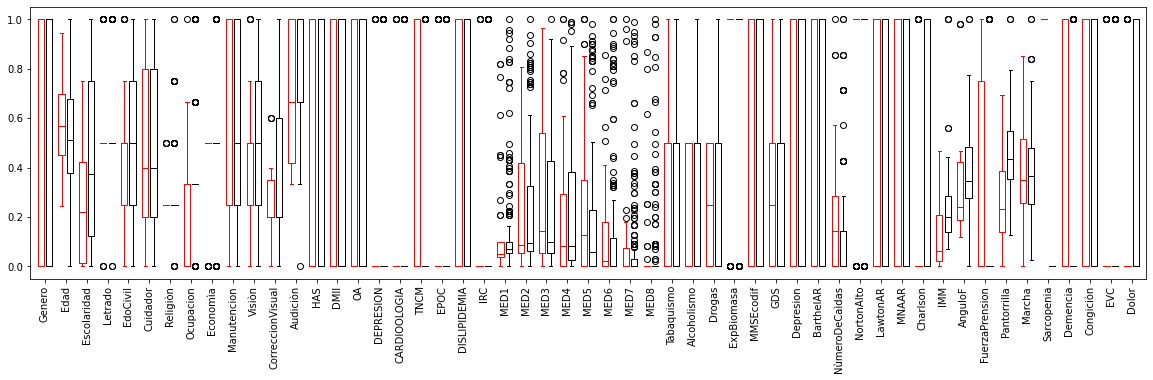

In [10]:
# function to get multiple boxplots as one figure
def draw_plot(data, offset, edge_color, fill_color, title):
    pos = np.arange(data.shape[1])+offset
    bp = ax.boxplot(data, positions= pos, widths=0.3, patch_artist=True)
    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)

# boxplot of serve and mild sarcopenia cases
fig, ax = plt.subplots(figsize=(20,5))
draw_plot(serve_sarco, -0.2, "red", "white", "Serve Sarcopenia (red) vs. mild Sarcopenia (black)")
draw_plot(mild_sarco, +0.2, "black", "white", "Serve Sarcopenia (red) vs. mild Sarcopenia (black)")
plt.xticks([i for i in range(data_norm.shape[1])], data_norm.columns, rotation=90)
plt.savefig("boxplot_serve_mild.png")
plt.show()

In [11]:
X = data_norm.drop("Sarcopenia", axis=1)
y = data_norm['Sarcopenia']

In [13]:
# functions to generate rankings

# transforms a dataframe generated by ranking functions to a dictionary
def df_to_dict(df):
    ranking = dict({key:[val] for key, val in zip(df['Feature'], df['Score'])})
    return ranking


# merges two dicts with the same keys
def merge_dict(dict1, dict2):
    for key in dict2.keys():
        dict2[key].extend(dict1[key])
    return  dict2


# generates ranking by a method applicable to SelectKBest, scales Score between 0 and 1
# returns dataframe with columns "Feature" and "Score"
def rank_by(X, y, method):
    sel = SelectKBest(method, k=10).fit(X,y)
    minmax = MinMaxScaler()
    df = pd.DataFrame(minmax.fit_transform(sel.scores_.reshape(-1,1)), columns=["Score"])
    df['Feature'] = sel.feature_names_in_
    return df

# generates ranking by feature importance from classifier clf
def rank_by_perm(X,y,clf):
    minmax = MinMaxScaler()
    perm_imp = permutation_importance(clf, X, y, n_repeats=30, random_state=42, n_jobs=-1)
    df = pd.DataFrame(minmax.fit_transform(perm_imp.importances_mean.reshape(-1,1)), columns=['Score'])
    df['Feature'] = X.columns
    return df

In [14]:
# split in hold out set and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# grid search on svc
svc = SVC()
C = [2**i for i in range(-4,6)]
gamma = ['scale', 'auto']
kernel = ['rbf', 'sigmoid', 'linear']
param_grid_svc = dict(kernel=kernel, C=C, gamma=gamma)
grid_svc = GridSearchCV(estimator=svc, param_grid=param_grid_svc, n_jobs=-1, scoring='accuracy')
grid_result_svc = grid_svc.fit(X_train, y_train)

# evaluation of gridSearch for svc
print('Best: %f using %s' ,(grid_result_svc.best_score_, grid_result_svc.best_params_))

results_svc = pd.DataFrame(grid_result_svc.cv_results_).sort_values(by='param_C')
#results_svc.sort_values('mean_test_score', ascending=False).head()

Best: %f using %s (0.8533033033033032, {'C': 2, 'gamma': 'scale', 'kernel': 'rbf'})


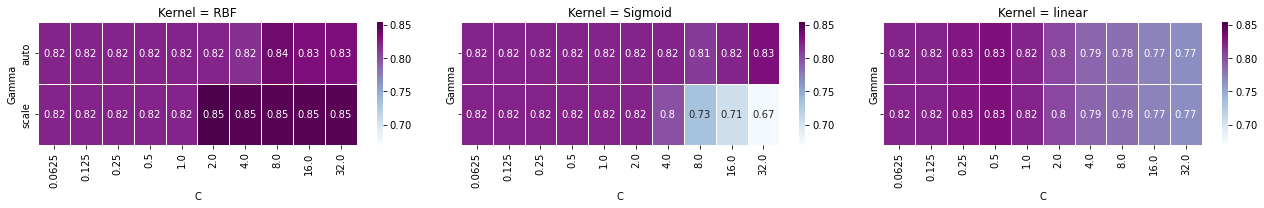

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [15]:
# generating heatmaps of parameter grid for svc
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,3), sharex=True, sharey=True)
hm1 = results_svc[results_svc['param_kernel']=='rbf'][['param_gamma', 'param_C', 'mean_test_score']]
hm1 = hm1.pivot('param_gamma', 'param_C', 'mean_test_score')
plt.figure()
heat_map1 = sns.heatmap(hm1, linewidth=1, annot=True, cmap='BuPu', vmax=grid_result_svc.best_score_, vmin=0.67, ax=ax1)
ax1.set_title('Kernel = RBF')
ax1.set_ylabel('Gamma')
ax1.set_xlabel('C')

hm2 = results_svc[results_svc['param_kernel']=='sigmoid'][['param_gamma', 'param_C', 'mean_test_score']]
hm2 = hm2.pivot('param_gamma', 'param_C', 'mean_test_score')
plt.figure()
heat_map2 = sns.heatmap(hm2, linewidth=1, annot=True, cmap='BuPu', vmax=grid_result_svc.best_score_, vmin=0.67, ax=ax2)
ax2.set_title('Kernel = Sigmoid')
ax2.set_ylabel('Gamma')
ax2.set_xlabel('C')

hm3 = results_svc[results_svc['param_kernel']=='linear'][['param_gamma', 'param_C', 'mean_test_score']]
hm3 = hm3.pivot('param_gamma', 'param_C', 'mean_test_score')
plt.figure()
heat_map3 = sns.heatmap(hm3, linewidth=1, annot=True, cmap='BuPu', vmax=grid_result_svc.best_score_, vmin=0.67, ax=ax3)
ax3.set_title('Kernel = linear')
ax3.set_ylabel('Gamma')
ax3.set_xlabel('C')

fig.tight_layout()

fig.savefig("heatmap_svc_hyperparameter.png")
plt.show()

In [16]:
# grid search on rf
rf = RandomForestClassifier(random_state=42)
# 1000 already a bit too much as we only have 231 entries in total
n_estimators = [50, 75, 100, 500, 1000]
criterion = ['gini', 'entropy']
max_depth = [i for i in range(4, len(X.columns)//2, 4)]
param_grid_rf = dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth)
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, n_jobs=-1, scoring='accuracy')
grid_result_rf = grid_rf.fit(X_train, y_train)

# evaluation of gridSearch for rf
print('Best: %f using %s' ,(grid_result_rf.best_score_, grid_result_rf.best_params_))

results_rf = pd.DataFrame(grid_result_rf.cv_results_)
#results_rf.sort_values('mean_test_score', ascending=False).head()

Best: %f using %s (0.9456456456456456, {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 1000})


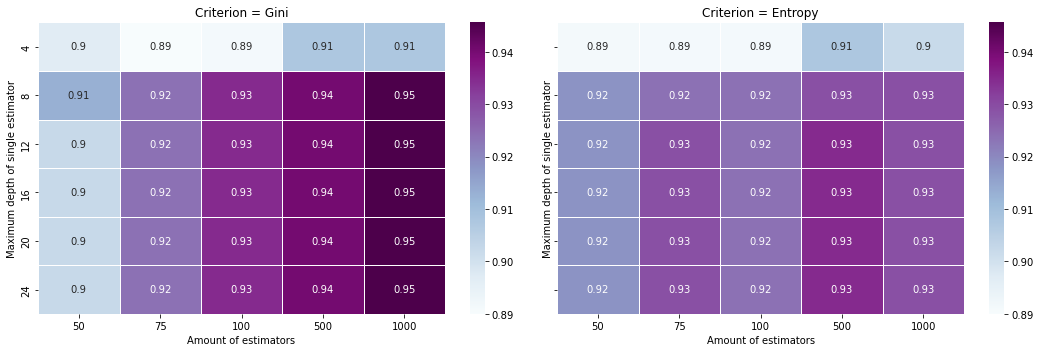

In [17]:
# visualisation of results of grid search for rf
results_rf = pd.DataFrame(grid_result_rf.cv_results_).sort_values(by=['param_max_depth', 'param_n_estimators'])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, sharey=True)
# generating heatmap of paramter grid for rf with crit=gini
hm1 = results_rf[results_rf['param_criterion'] == 'gini'][['param_max_depth', 'param_n_estimators', 'mean_test_score']]
hm1 = hm1.pivot('param_max_depth', 'param_n_estimators', 'mean_test_score')
heat1 = sns.heatmap(hm1, linewidth = 1 , annot = True, cmap='BuPu', vmax=grid_result_rf.best_score_, vmin=0.89, ax=ax1)
heat1.set_title('Criterion = Gini')
heat1.set_ylabel('Maximum depth of single estimator')
heat1.set_xlabel('Amount of estimators')

# generating heatmap of paramter grid for rf with crit=entropy
hm2 = results_rf[results_rf['param_criterion'] == 'entropy'][['param_max_depth', 'param_n_estimators', 'mean_test_score']]
hm2 = hm2.pivot('param_max_depth', 'param_n_estimators', 'mean_test_score')
heat2 = sns.heatmap(hm2, linewidth = 1 , annot = True, cmap='BuPu', vmax=grid_result_rf.best_score_, vmin=0.89, ax=ax2)
heat2.set_title('Criterion = Entropy')
heat2.set_ylabel('Maximum depth of single estimator')
heat2.set_xlabel('Amount of estimators')

plt.tight_layout()
fig.savefig('heatmap_rf_hyperparameter.png')
plt.show()

In [18]:
random.seed(42)

# models with best params and fitting
rf = RandomForestClassifier(n_estimators=1000, max_depth=8, criterion='gini').fit(X_train, y_train)
svc = SVC(kernel='rbf', C=2, gamma='scale').fit(X_train, y_train)

# get rankings for chi2, f1 and rf
ranking_chi2 = df_to_dict(rank_by(X,y, chi2))
ranking_f1 = df_to_dict(rank_by(X,y, f_classif))
ranking_rf = df_to_dict(rank_by_perm(X,y,rf))
ranking_svc = df_to_dict(rank_by_perm(X,y,svc))

ranking_all = merge_dict(ranking_chi2, merge_dict(ranking_f1, merge_dict(ranking_rf, ranking_svc)))

In [25]:
# generate final ranking by summing up he scores and sorting
ranking_final = dict()
for key, val in zip(ranking_all.keys(), ranking_all.values()):
    score = np.array(val).sum()
    # print(str(key)+": "+ str(score))
    ranking_final.update({key : score})

sorted(ranking_final.items(), key= lambda x : x[1])


Genero: 0.5827327937726843
Edad: 0.4112730528070136
Escolaridad: 0.21240302625799495
Letrado: 0.32474837279716806
EdoCivil: 0.46497168859371785
Cuidador: 0.36760710577176814
Religiòn: 0.3342589739223741
Ocupacion: 0.5462459768438457
Economìa: 0.2993474321641942
Manutencion: 0.2287742385832877
Visiòn: 0.12374511196523516
CorreccionVisual: 0.6739211835148926
Audiciòn: 0.5124654043291818
HAS: 0.9409263853481926
DMII: 0.40175242566500363
OA: 0.4217290643819712
DEPRESION: 0.42905451081220225
CARDIOOLOGIA: 1.0706773784056853
TNCM: 1.4087565810889027
EPOC: 0.9483671786233233
DISLIPIDEMIA: 0.5676450800416927
IRC: 0.46186275771755925
MED1: 0.32932638824420063
MED2: 0.16286929868774688
MED3: 0.09864998296612404
MED4: 0.2767756733178734
MED5: 0.8523891326819103
MED6: 0.2744599930673041
MED7: 0.5311950679547839
MED8: 0.33410430102814154
Tabaquismo: 0.4869034599931222
Alcoholismo: 0.31656088230084933
Drogas: 0.181880404900467
ExpBiomasa: 0.44809708112748614
MMSEcodif: 0.4693880054394323
GDS: 0.2955

[('MED3', 0.09864998296612404),
 ('Visiòn', 0.12374511196523516),
 ('MED2', 0.16286929868774688),
 ('Drogas', 0.181880404900467),
 ('Escolaridad', 0.21240302625799495),
 ('Manutencion', 0.2287742385832877),
 ('MED6', 0.2744599930673041),
 ('MED4', 0.2767756733178734),
 ('GDS', 0.29551582885222283),
 ('Economìa', 0.2993474321641942),
 ('Alcoholismo', 0.31656088230084933),
 ('Letrado', 0.32474837279716806),
 ('MED1', 0.32932638824420063),
 ('MED8', 0.33410430102814154),
 ('Religiòn', 0.3342589739223741),
 ('Marcha', 0.35387736744253007),
 ('Cuidador', 0.36760710577176814),
 ('NortonAlto', 0.38344256723887965),
 ('DMII', 0.40175242566500363),
 ('Edad', 0.4112730528070136),
 ('OA', 0.4217290643819712),
 ('DEPRESION', 0.42905451081220225),
 ('AnguloF', 0.4476259157884597),
 ('ExpBiomasa', 0.44809708112748614),
 ('IRC', 0.46186275771755925),
 ('EdoCivil', 0.46497168859371785),
 ('MMSEcodif', 0.4693880054394323),
 ('EVC', 0.4836535099179384),
 ('Tabaquismo', 0.4869034599931222),
 ('Audiciòn',